In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from tensorflow import keras
import cv2
import glob
import numpy as np

tf.config.experimental.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [17]:
trainX_paths = sorted(glob.glob('floods_dataset/train/images/*.jpg'))
trainY_paths = sorted(glob.glob('floods_dataset/train/masks/*.png'))

valX_paths = sorted(glob.glob('floods_dataset/validation/images/*.jpg'))
valY_paths = sorted(glob.glob('floods_dataset/validation/masks/*.png'))

testX_paths = sorted(glob.glob('floods_dataset/test/images/*.jpg'))
testY_paths = sorted(glob.glob('floods_dataset/test/masks/*.png'))

print(len(trainX_paths), len(trainY_paths))
print(len(valX_paths), len(valY_paths))
print(len(testX_paths), len(testY_paths))

1200 1200
180 180
360 360


In [18]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = x / 255.0
    x = np.expand_dims(x, axis=-1)
    x = x.astype(np.float32)
    
    return x

def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()
        
        x = read_image(x)
        y = read_mask(y)
        
        return x, y
    
    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    image.set_shape([224, 224, 3])
    mask.set_shape([224, 224, 1])
    
    return image, mask

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset

In [19]:
train_dataset = tf_dataset(trainX_paths, trainY_paths, batch=8)
val_dataset = tf_dataset(valX_paths, valY_paths, batch=8)
test_dataset = tf_dataset(testX_paths, testY_paths, batch=8)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [25]:
input = keras.Input(shape=(224, 224, 3))

x = keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',)(input)
x_l1 = keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',)(x)

x = keras.layers.MaxPool2D(pool_size=(2, 2))(x_l1)

x = keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu',)(x)
x_l2 = keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu',)(x)

x = keras.layers.MaxPool2D(pool_size=(2, 2))(x_l2)

x = keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu',)(x)
x_l3 = keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu',)(x)

x = keras.layers.MaxPool2D(pool_size=(2, 2))(x_l3)

x = keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',)(x)
x_l4 = keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',)(x)

x = keras.layers.MaxPool2D(pool_size=(2, 2))(x_l4)

x = keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu',)(x)
x_l5 = keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu',)(x)

x = keras.layers.MaxPool2D(pool_size=(2, 2))(x_l5)

x = keras.layers.Conv2D(filters=1024, kernel_size=3, padding='same', activation='relu',)(x)
x = keras.layers.Conv2D(filters=1024, kernel_size=3, padding='same', activation='relu',)(x)



# x = keras.layers.Conv2DTranspose(filters=1024, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = keras.layers.UpSampling2D(size=(2, 2))(x)
x = keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu',)(x)

x = keras.layers.concatenate([x_l5, x], axis=3)

x = keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu',)(x)
x = keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu',)(x)


x = keras.layers.UpSampling2D(size=(2, 2))(x)
x = keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',)(x)

x = keras.layers.concatenate([x_l4, x], axis=3)

x = keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',)(x)
x = keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',)(x)





x = keras.layers.UpSampling2D(size=(2, 2))(x)
x = keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu',)(x)

x = keras.layers.concatenate([x_l3, x], axis=3)

x = keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu',)(x)
x = keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu',)(x)




x = keras.layers.UpSampling2D(size=(2, 2))(x)
x = keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu',)(x)

x = keras.layers.concatenate([x_l2, x], axis=3)

x = keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu',)(x)
x = keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu',)(x)




x = keras.layers.UpSampling2D(size=(2, 2))(x)
x = keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',)(x)

x = keras.layers.concatenate([x_l1, x], axis=3)

x = keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',)(x)
x = keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',)(x)

x = keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',)(x)



output = keras.layers.Conv2D(filters=2, kernel_size=1, padding='same', activation='softmax',)(x)


model = keras.Model(input, output)
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_255 (Conv2D)            (None, 224, 224, 32  896         ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_256 (Conv2D)            (None, 224, 224, 32  9248        ['conv2d_255[0][0]']             
                                )                                                          

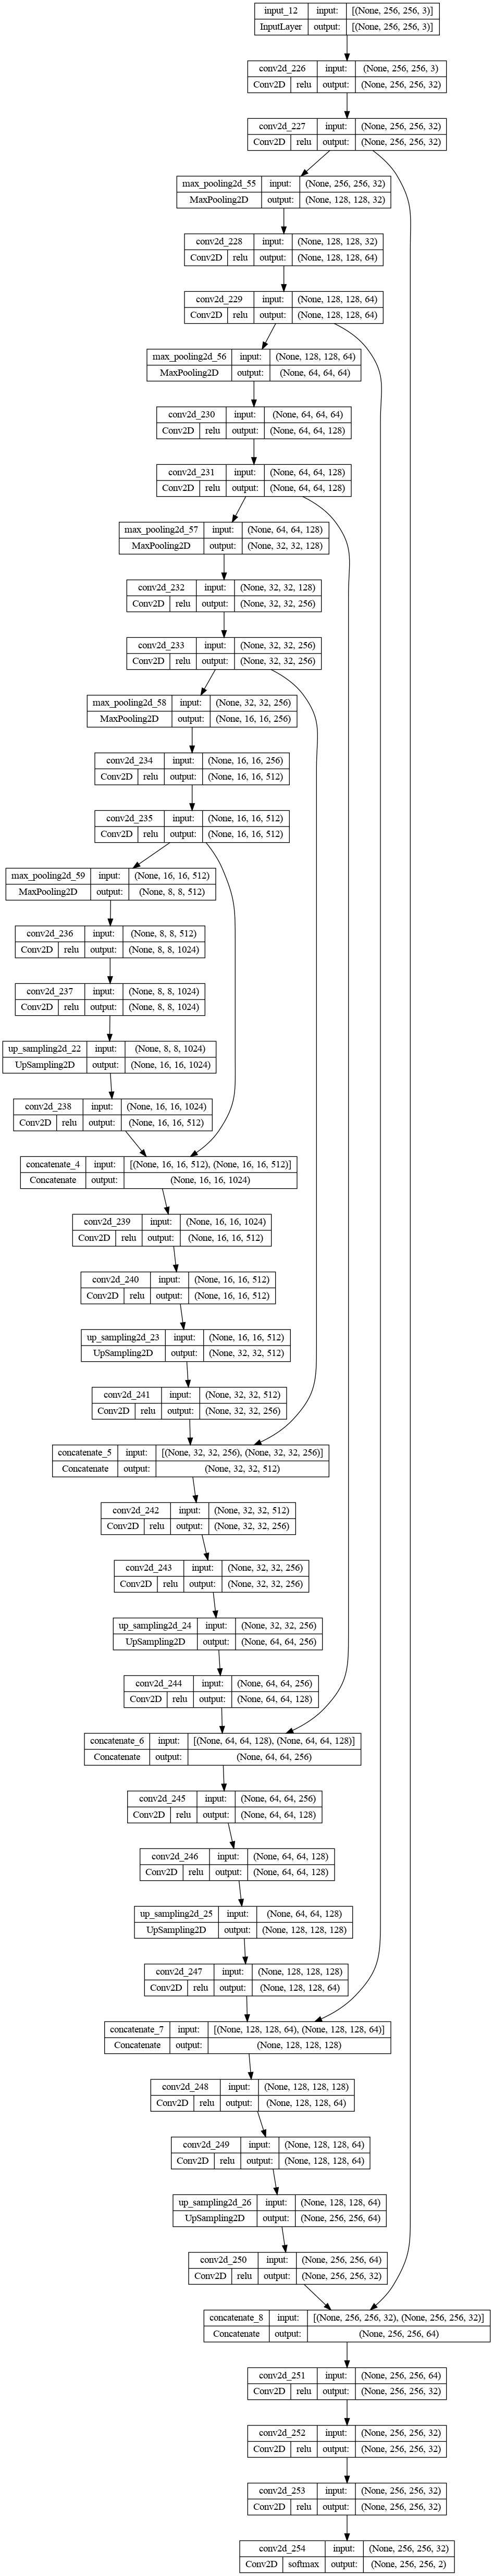

In [16]:
keras.utils.plot_model(model, to_file='unet.png', show_layer_activations=True, show_shapes=True)

In [26]:
import matplotlib.pyplot as plt

def display_mask(pred):
    plt.figure(figsize=(16, 16))
    plt.axis('off')
    mask = np.argmax(pred, axis=-1)
    mask *= 255
    # plt.imshow(mask)
    
def display(x, y, pred, fname, index=0,):
    fig = plt.figure(figsize=(16, 16))
    # plt.axis('off')
    
    mask = np.argmax(pred[index], axis=-1)
    mask *= 255
    
    plt.subplot(1, 3, 1)
    plt.imshow(x[index].numpy())
    
    
    plt.subplot(1, 3, 2)
    plt.imshow(y[index].numpy())
    
    
    
    plt.subplot(1, 3, 3)
    plt.imshow(mask)
    fig.savefig(fname)
    plt.close()

In [27]:
!rm -rf progress/unet
!mkdir progress/unet

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.RMSprop(),)

def custom_lr(epoch, lr):
    if epoch %10 == 0 and epoch != 0:
        return lr / 10
    else:
        return lr


class PlotCallback(keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        
        for x, y in val_dataset:
            preds = model.predict(x)
            tx = x
            ty = y
            break
        
        display(tx, ty, preds, fname=f'progress/unet/epoch_{epoch}.png', index=5,)
        

In [28]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=[keras.callbacks.TensorBoard(), keras.callbacks.LearningRateScheduler(custom_lr), PlotCallback(), keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/50


150/150 [==============================] - 48s 216ms/step - loss: 0.5519 - val_loss: 0.5100 - lr: 0.0010
Epoch 2/50
150/150 [==============================] - 32s 213ms/step - loss: 0.4684 - val_loss: 0.4347 - lr: 0.0010
Epoch 3/50
150/150 [==============================] - 31s 206ms/step - loss: 0.4527 - val_loss: 0.4164 - lr: 0.0010
Epoch 4/50
150/150 [==============================] - 31s 207ms/step - loss: 0.4395 - val_loss: 0.4482 - lr: 0.0010
Epoch 5/50
150/150 [==============================] - 31s 208ms/step - loss: 0.4290 - val_loss: 0.4021 - lr: 0.0010
Epoch 6/50
150/150 [==============================] - 32s 213ms/step - loss: 0.4171 - val_loss: 0.3947 - lr: 0.0010
Epoch 7/50
150/150 [==============================] - 33s 222ms/step - loss: 0.4074 - val_loss: 0.3476 - lr: 0.0010
Epoch 8/50
150/150 [==============================] - 33s 222ms/step - loss: 0.4045 - val_loss: 0.4148 - lr: 0.0010
Epoch 9/50
150/150 [==============================] - 33s 220ms/step - loss: 0.3955

<AxesSubplot: >

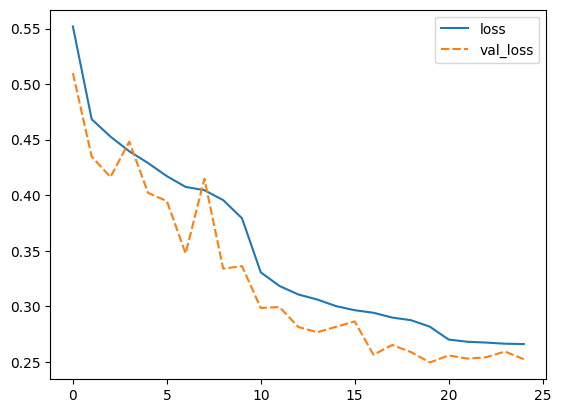

In [29]:
import seaborn as sns

sns.lineplot(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})